<a href="https://colab.research.google.com/github/KatarinaKozina/machine-learning/blob/master/BraTS2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


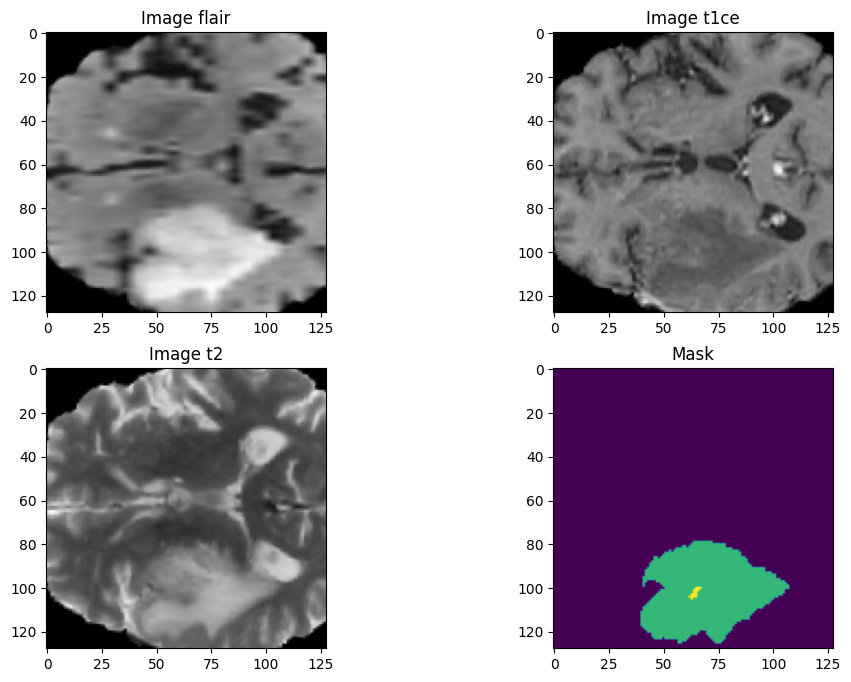

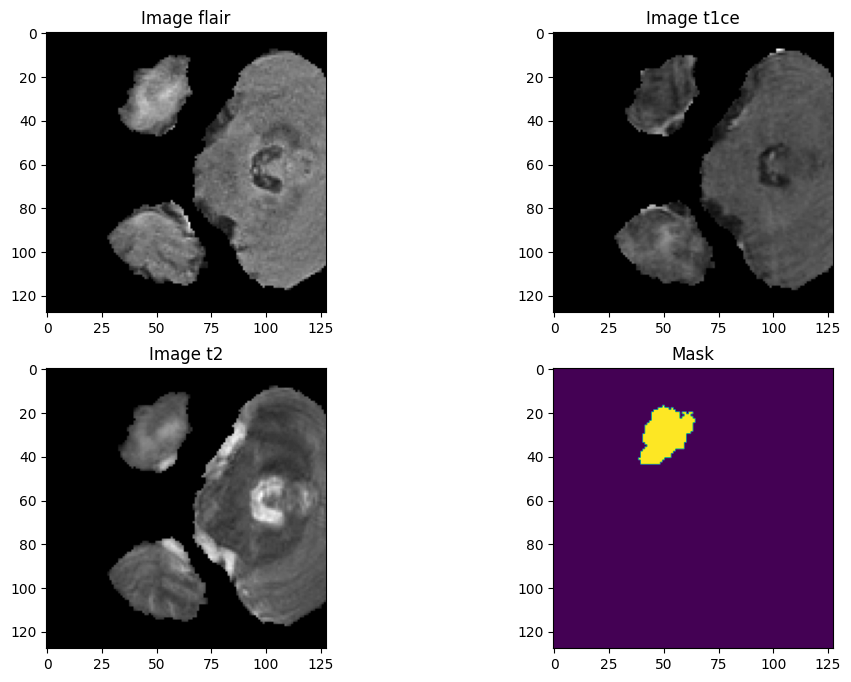

Segmentation Models: using `tf.keras` framework.


In [ ]:
import sys
import os
import numpy as np
path_to_module = '/content/drive/MyDrive/'
sys.path.append(path_to_module)
from u_net_data_gen import imageLoader
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random



####################################################
train_img_dir = '/content/drive/MyDrive/input_data_128/input_data_128/train/images/'
train_mask_dir = '/content/drive/MyDrive/input_data_128/input_data_128/train/masks/'

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


##############################################################
#Define the image generators for training and validation

train_img_dir = '/content/drive/MyDrive/input_data_128/input_data_128/train/images/'
train_mask_dir = '/content/drive/MyDrive/input_data_128/input_data_128/train/masks/'

val_img_dir = '/content/drive/MyDrive/input_data_128/input_data_128/val/images/'
val_mask_dir = '/content/drive/MyDrive/input_data_128/input_data_128/val/masks/'

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################

########################################################################
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


###########################################################################
#Define loss, metrics and optimizer to be used for training
#wt0, wt1, wt2, wt3 = 0.26,23.01,8.82,28.25
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
#dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
jaccard_loss = sm.losses.JaccardLoss()
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
binary_focal_loss = sm.losses.BinaryFocalLoss()
categorical_focal_loss = sm.losses.CategoricalFocalLoss()
binary_crossentropy = sm.losses.BinaryCELoss()
categorical_crossentropy = sm.losses.CategoricalCELoss(class_weights=np.array([wt0, wt1, wt2, wt3]))

# loss combinations
bce_dice_loss = binary_crossentropy + dice_loss
bce_jaccard_loss = binary_crossentropy + jaccard_loss

cce_dice_loss = categorical_crossentropy + dice_loss
cce_jaccard_loss = categorical_crossentropy + jaccard_loss

binary_focal_dice_loss = binary_focal_loss + dice_loss
binary_focal_jaccard_loss = binary_focal_loss + jaccard_loss

categorical_focal_dice_loss = categorical_focal_loss + dice_loss
categorical_focal_jaccard_loss = categorical_focal_loss + jaccard_loss

total_loss = dice_loss

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)
#######################################################################
#Fit the model

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

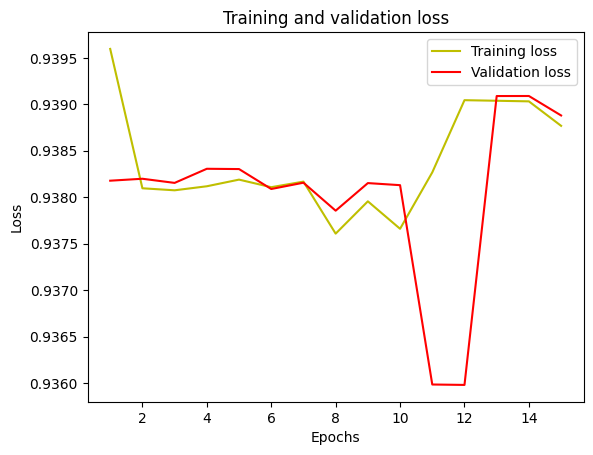

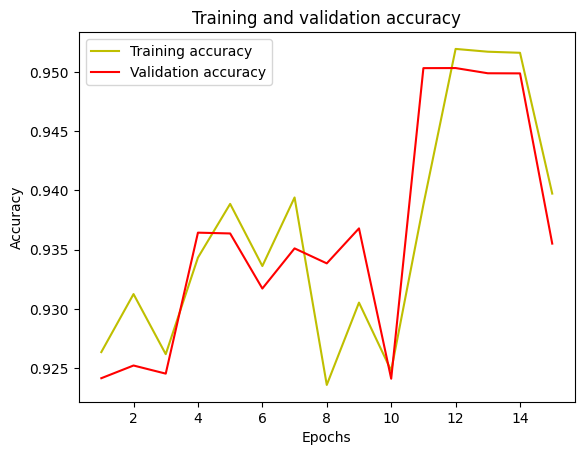

In [ ]:
############ for training model from scratch
from u_net_simple_3d import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=15,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
print(history)
model.save('/content/drive/MyDrive/brats_3d_15epochs_dice_loss_v2.hdf5')
##################################################################

#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

import pandas as pd
# Create a dataframe with training history
history_df = pd.DataFrame(history.history)

# Save the dataframe to an Excel file
history_df.to_excel('/content/drive/MyDrive/training_history_dice_loss_v2.xlsx', index=False)

In [ ]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.to_excel('training_history_CE.xlsx', index=False)

In [ ]:



######Loading model and continue with training
from keras.models import load_model



#Now, let us add the iou_score function we used during our initial training
my_model = load_model('/content/drive/MyDrive/brats_3d_130epochs.hdf5/',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
history=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=15,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_model.save('/content/drive/MyDrive/brats_3d_145epochs.hdf5')

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




#For predictions you do not need to compile the model, so ...
my_model = load_model('/content/drive/MyDrive/brats_3d_145epochs.hdf5',
                      compile=False)





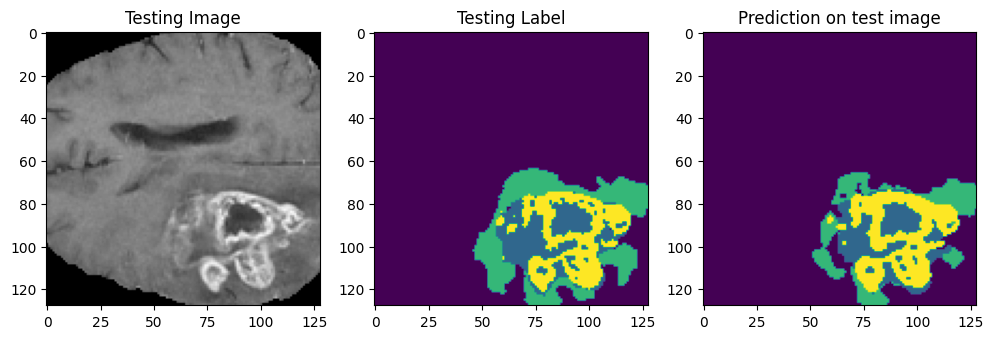

In [ ]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU
import numpy as np

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)
import tensorflow as tf

n_classes = 4

# Initialize a list to store the IoU scores for each class
iou_scores = []
dice_coeffs = []
Sensitivity = []
Specificity = []
# Create a new instance of the MeanIoU metric
iou_metric = tf.keras.metrics.MeanIoU(num_classes=n_classes)

# Update the metric with the predicted and ground truth masks
iou_metric.update_state(test_mask_batch_argmax, test_pred_batch_argmax)

# Get the overall IoU score
mean_iou = iou_metric.result().numpy()

# Compute the per-class IoU scores
for class_id in range(n_classes):
    # Get the number of true positives, false positives, and false negatives for the current class
    true_negatives = np.sum((test_pred_batch_argmax != class_id) & (test_mask_batch_argmax != class_id))
    true_positives = np.sum((test_pred_batch_argmax == class_id) & (test_mask_batch_argmax == class_id))
    false_positives = np.sum((test_pred_batch_argmax == class_id) & (test_mask_batch_argmax != class_id))
    false_negatives = np.sum((test_pred_batch_argmax != class_id) & (test_mask_batch_argmax == class_id))

    # Compute the IoU score, dice coeffs, sensitivity and specificity for the current class
    iou_score = true_positives / (true_positives + false_positives + false_negatives + 1e-7)
    dice_coeff = (2.0 * true_positives) / (2.0 * true_positives + false_positives + false_negatives) if (2.0 * true_positives + false_positives + false_negatives) != 0 else 1.0
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity =  true_negatives / (true_negatives + false_positives)
    # Add the IoU score to the list
    iou_scores.append(iou_score)
    dice_coeffs.append(dice_coeff)
    Specificity.append(specificity)
    Sensitivity.append(sensitivity)

# Print the overall and per-class IoU scores
print(f"Mean IoU: {mean_iou}")
for class_id, iou_score in enumerate(iou_scores):
    print(f"IoU for class {class_id}: {iou_score}")

print("Dice coeff")
for class_id, dice_coeff in enumerate(dice_coeffs):
    print(f"Dice Coeffs {class_id}: {dice_coeff}")

print("Sensitivity")
for class_id, sensitivity in enumerate(Sensitivity):
    print(f"Sensitivity {class_id}: {sensitivity}")

print("Specificity")
for class_id, specificity in enumerate(Specificity):
    print(f"Specificity {class_id}: {specificity}")


#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = 207

test_img = np.load("/content/drive/MyDrive/input_data_128/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/input_data_128/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

import numpy as np
import matplotlib.pyplot as plt

# Assuming test_prediction_argmax is your 3D prediction
# test_prediction_argmax.shape should be (height, width, depth)

# You can create slices along the three axes (x, y, and z) and visualize them
num_slices = test_prediction_argmax.shape[2]
num_rows = 10
num_cols = num_slices // num_rows + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(num_slices):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(test_prediction_argmax[:, :, i], cmap='jet')  # Adjust the cmap as needed
    ax.set_title(f"Slice {i}")

    # Hide ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Hide any remaining empty subplots
for i in range(num_slices, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.show()
# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 80
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

############################################################

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
pip install segmentation-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 6.3 MB/s eta 0:00:00
